In [162]:
%load_ext autoreload
%autoreload 2
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import tensorflow_probability
from tensorflow_probability.python.internal.backend import jax as tf2jax
tfp = tensorflow_probability.experimental.substrates.jax
tfk = tfp.math.psd_kernels
import optax
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import sys; sys.path.insert(0, '..')
from riemannianvectorgp.sparse_gp import SparseGaussianProcess
from riemannianvectorgp.gp import GaussianProcess
from riemannianvectorgp.kernel import ScaledTFPKernel, FourierFeatures, ScaledKernel, TFPKernel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
def plot(x,y,f, samples=False):
    m = jnp.mean(f, axis=0)
    u = jnp.quantile(f, 0.975, axis=0)
    l = jnp.quantile(f, 0.025, axis=0)
    
    fig = plt.figure()
    # ax = fig.add_subplot(projection='polar')
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.plot(x,m,linewidth=2)
    ax.fill_between(x, l, u, alpha=0.5)
    
    if samples:
        for i in range(f.shape[0]):
            ax.plot(x,f[i,:], color="gray",alpha=0.5)

class GlobalRNG:
    def __init__(self, seed: int = np.random.randint(2147483647)):
        self.key = jax.random.PRNGKey(seed)

    def __iter__(self):
        return self
    
    def __next__(self):
        (ret_key, self.key) = jr.split(self.key)
        return ret_key


def plot_gp(x, y, gp, params, state, samples=False):


    fig, axs = plt.subplots(3,1, figsize=(4, 9))

    state = gp.randomize(params, state, next(rng))
    inducing_mean = tf2jax.linalg.matvec(
        gp.kernel.matrix(params.kernel_params, params.inducing_locations, params.inducing_locations) + jax.vmap(jnp.diag)(jnp.exp(2 * params.inducing_pseudo_log_err_stddev)), 
        params.inducing_pseudo_mean
    )

    f = gp(params, state, x)[:, 0, :]
    f_prior = gp.prior(params.kernel_params, state.prior_state, x)[:, 0, :]

    k = kernel.matrix(params.kernel_params, x, x)[0, :, 0]

    x = x[:, 0]
    y = y[0, :]

    axs[0].scatter(x, y)
    # ax.set_rmin-(-4)

    m = jnp.mean(f, axis=0)
    u = jnp.quantile(f, 0.975, axis=0)
    l = jnp.quantile(f, 0.025, axis=0)

    axs[0].plot(x, m, linewidth=2)
    axs[0].fill_between(x, l, u, alpha=0.5)

    if samples:
        for i in range(f.shape[0]):
            axs[0].plot(x, f[i, :], color="gray", alpha=0.5)

    axs[0].scatter(params.inducing_locations[:,0], inducing_mean)
    axs[0].errorbar(
        params.inducing_locations[:,0],
        inducing_mean[0],
        yerr=jnp.exp(params.inducing_pseudo_log_err_stddev[0]),
        linestyle='none'
    )
    axs[0].set_title("Sparse GP")
    axs[1].plot(x, f_prior.T)
    axs[1].set_title("Prior samples")
    axs[2].plot(x, k)
    axs[2].set_title('Kernel')

    plt.tight_layout()

In [164]:
rng = GlobalRNG()

In [165]:
x = jnp.expand_dims(jnp.linspace(-5,5,101), -1)
y = 2 * jnp.sin(x).T + jr.normal(next(rng), x.T.shape)/10

In [166]:
kernel = ScaledTFPKernel(tfk.ExponentiatedQuadratic,1,1)
kernel_params = kernel.init_params(next(rng))

In [167]:
kernel = ScaledKernel(TFPKernel(tfk.ExponentiatedQuadratic, 1, 1))
kernel_params = kernel.init_params(next(rng))
kernel_params

ScaledKernelParams(log_amplitude=DeviceArray([0.], dtype=float32), sub_kernel_params=TFPKernelParameters(log_length_scales=DeviceArray([0.], dtype=float32)))

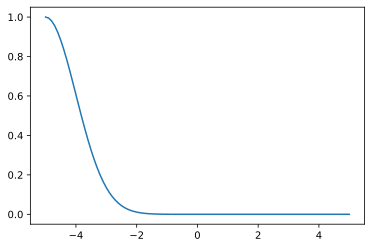

In [168]:
k = kernel.matrix(kernel_params, x, x)
plt.plot(x[:, 0], k[0, :, 0])

In [169]:
gp = SparseGaussianProcess(kernel, 1, 1, 11, 67, 100)
(params, state) = gp.init_params_with_state(next(rng))

In [170]:
params = params._replace(inducing_locations = jnp.expand_dims(jnp.linspace(-5,5,11), -1))

In [171]:
state = gp.resample_prior_basis(params,state,next(rng))
state = gp.randomize(params,state,next(rng))

In [172]:
gp.loss(params,state,next(rng),x,y,x.shape[0])[0]

DeviceArray(125.943825, dtype=float32)

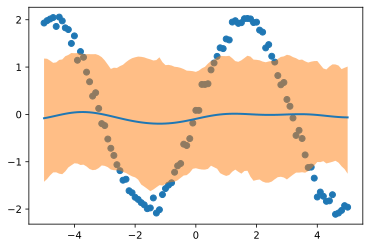

In [173]:
state = gp.randomize(params,state,next(rng))
plot(x[:,0],y[0,:],gp(params,state,x)[:,0,:])

In [174]:
opt = optax.chain(optax.scale_by_adam(b1=0.9, b2=0.999, eps=1e-8), optax.scale(-0.01))
opt_state = opt.init(params)

In [175]:
for i in range(300):
    ((train_loss,state),grads) = jax.value_and_grad(gp.loss, has_aux=True)(params,state,next(rng),x,y,x.shape[0])
    (updates,opt_state) = opt.update(grads, opt_state)
    params = optax.apply_updates(params,updates)
    if i <= 10 or i % 20 == 0: print(i,"Loss:",train_loss)

0 Loss: 129.94913
1 Loss: 126.6009
2 Loss: 123.70628
3 Loss: 115.93538
4 Loss: 118.37307
5 Loss: 112.03214
6 Loss: 106.210724
7 Loss: 106.34649
8 Loss: 101.79464
9 Loss: 98.23116
10 Loss: 98.97784
20 Loss: 81.08806
40 Loss: 54.37747
60 Loss: 32.7118
80 Loss: 10.888326
100 Loss: -8.663252
120 Loss: -29.299767
140 Loss: -47.557217
160 Loss: -65.296074
180 Loss: -82.2966
200 Loss: -94.93428
220 Loss: -107.59101
240 Loss: -115.00839
260 Loss: -123.50577
280 Loss: -126.192474


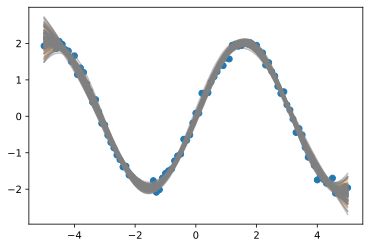

In [176]:
state = gp.randomize(params,state,next(rng))
plot(x[:,0],y[0,:],gp(params,state,x)[:,0,:], samples=True)

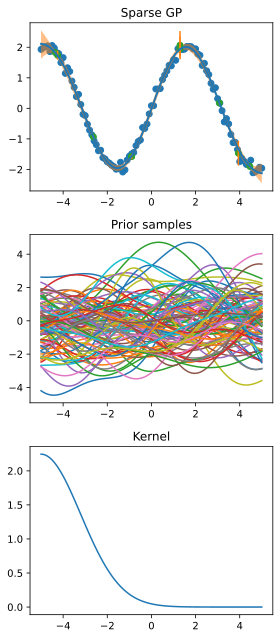

In [177]:
plot_gp(x, y, gp, params, state, samples=False)

In [137]:
x_ind = jnp.expand_dims(jnp.linspace(-5, 5, 11), -1)
yi = 2 * jnp.sin(x_ind).T

params = gp.set_inducing_points(
    params,
    x_ind,
    yi,
    jnp.ones_like(yi) * 1.0
)

In [64]:
gp_dense = GaussianProcess(kernel, 1, 1, 10)
(dense_params, dense_state) = gp_dense.init_params_with_state(next(rng))
dense_params = dense_params._replace(kernel_params=kernel_params)
dense_state = gp_dense.condition(dense_params, x, y, 0.1 * jnp.ones_like(x)[:, 0], next(rng))


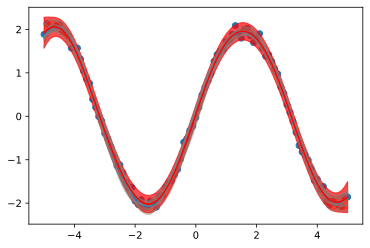

In [72]:
# dense_state = gp_dense.randomize(dense_params, dense_state, next(rng))

m, K = gp_dense(dense_params, dense_state, x)
samples = gp_dense.sample(dense_params, dense_state, x, next(rng), obs_noise=1e-5)

plot(x[:, 0], y[0, :], samples[:, 0, :], samples=True)
k = jnp.sqrt(jnp.diagonal(K[0]))
plt.plot(x[:, 0], m[0, :], color='red')
plt.fill_between(x[:, 0], m[0, :] - (k * 1.96), m[0, :] + (k * 1.96), color='red', alpha=0.7)

In [71]:
K[0].shape

(101, 101)

In [34]:
x = jnp.expand_dims(jnp.linspace(-5,5,101)[0:30:3], -1)
x_dense = jnp.expand_dims(jnp.linspace(-5,5,101), -1)
y = 2 * jnp.sin(x).T + jr.normal(next(rng), x.T.shape)/10

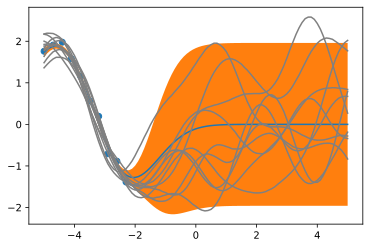

In [47]:
gp_dense = GaussianProcess(kernel, 1, 1, 10)
(dense_params, dense_state) = gp_dense.init_params_with_state(next(rng))
dense_params = dense_params._replace(kernel_params=kernel_params)
dense_state = gp_dense.condition(dense_params, x, y, 0.1 * jnp.ones_like(x)[:, 0], next(rng))

m, K = gp_dense(dense_params, dense_state, x_dense)
samples = gp_dense.sample(dense_params, dense_state, x_dense, next(rng), obs_noise=1e-5)
k = jnp.diagonal(K[0,:,:])

plt.scatter(x[:,0], y[0, :])
plt.plot(x_dense[:,0], m[0,:])
plt.fill_between(x_dense[:,0], m[0,:]-(k* 1.96), m[0,:]+(k* 1.96), zorder=2)
for i in range(samples.shape[0]):
    plt.plot(x_dense[:,0], samples[i, 0 ,:], color='grey', zorder=5)

In [44]:
samples

DeviceArray([[[nan, nan, nan, ..., nan, nan, nan]],

             [[nan, nan, nan, ..., nan, nan, nan]],

             [[nan, nan, nan, ..., nan, nan, nan]],

             ...,

             [[nan, nan, nan, ..., nan, nan, nan]],

             [[nan, nan, nan, ..., nan, nan, nan]],

             [[nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)